In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wsn-fault-nodes/WsnData (1).csv


In [2]:
df = pd.read_csv("/kaggle/input/wsn-fault-nodes/WsnData (1).csv")

In [3]:
df.head()

,SensorID,Timestamp,SensorType,X,Y,SensorData,BatteryLife,Temperature,IsFaulty
0,1,18-Apr-2024 22:41:44,Temperature,32.300556,21.575965,51.396271,73.533551,53.793287,0
1,2,18-Apr-2024 22:41:45,Humidity,61.588405,96.030429,15.024628,73.435270,50.867584,0
2,3,18-Apr-2024 22:41:46,Pressure,17.543522,75.573323,62.117307,73.372619,49.905307,0
3,4,18-Apr-2024 22:41:47,Temperature,75.932405,92.519359,75.547331,73.281948,49.990236,0
4,5,18-Apr-2024 22:41:48,Humidity,13.461775,14.773697,20.536293,73.227014,48.288018,0


In [4]:
data=df.drop('X',axis=1)
data=data.drop('Y',axis=1)

In [5]:
data = data.sample(frac=1)

In [6]:
data.head()

,SensorID,Timestamp,SensorType,SensorData,BatteryLife,Temperature,IsFaulty
3853,54,18-Apr-2024 22:42:37,Pressure,28.649774,22.288095,50.686705,0
4863,64,18-Apr-2024 22:42:47,Temperature,73.273901,65.065099,16.870903,0
7338,39,18-Apr-2024 22:42:22,Pressure,85.355282,45.860790,70.158472,0
9394,95,18-Apr-2024 22:43:18,Humidity,62.189167,5.526411,58.777059,1
467,68,18-Apr-2024 22:42:51,Humidity,50.413697,84.870053,33.885209,0


In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from collections import defaultdict

# Define the environment class
class SensorEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.max_steps = len(data)
    
    def reset(self):
        self.current_step = 0
        
    def step(self, action):
        # Execute the action
        is_faulty = self.data.iloc[self.current_step]['IsFaulty']
        reward = 1 if action == is_faulty else -10
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.data.iloc[self.current_step] if not done else None
        return tuple(next_state) if next_state is not None else None, reward, done


# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size
        
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        if next_state is None:
            td_target = reward
        else:
            td_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        
    def train(self, env, episodes):
        for episode in range(episodes):
            state = tuple(env.data.iloc[episode])
            env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state

                
# Load data
data = pd.DataFrame({
    'SensorID': [5, 21, 94, 65, 43],
    'Timestamp': ['18-Apr-2024 22:41:48', '18-Apr-2024 22:42:04', '18-Apr-2024 22:43:17', '18-Apr-2024 22:42:48', '18-Apr-2024 22:42:26'],
    'SensorType': ['Humidity', 'Pressure', 'Temperature', 'Humidity', 'Temperature'],
    'SensorData': [73.207590, 69.166445, 11.986395, -0.342599, -7.688521],
    'BatteryLife': [2.680539, 33.300421, 68.603829, 67.178232, 3.935005],
    'Temperature': [28.004203, 54.250349, 51.754191, 0.515658, 43.608114],
    'IsFaulty': [1, 0, 0, 1, 1]
})

# Initialize environment and agent
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_env = SensorEnvironment(train_data)
agent = QLearningAgent(state_size=len(data.columns) - 1, action_size=2)  # Excluding the 'IsFaulty' column

# Train the agent
agent.train(train_env, episodes=len(train_data))

# Extract and print the Q-table
print("Q-table:")
for state, action_values in agent.q_table.items():
    print("State:", state)
    print("Action values:", action_values)



Q-table:
State: (43, '18-Apr-2024 22:42:26', 'Temperature', -7.688521, 3.935005, 43.608114, 1)
Action values: [-1.  0.]
State: (94, '18-Apr-2024 22:43:17', 'Temperature', 11.986395, 68.603829, 51.754191, 0)
Action values: [-0.69226829 -1.8901981 ]
State: (5, '18-Apr-2024 22:41:48', 'Humidity', 73.20759, 2.680539, 28.004203, 1)
Action values: [-1.        0.303409]
State: (65, '18-Apr-2024 22:42:48', 'Humidity', -0.342599, 67.178232, 0.515658, 1)
Action values: [-1.        0.270919]


Total reward on train data: -36000
Total reward on test data: -8846
Accuracy: -4.423


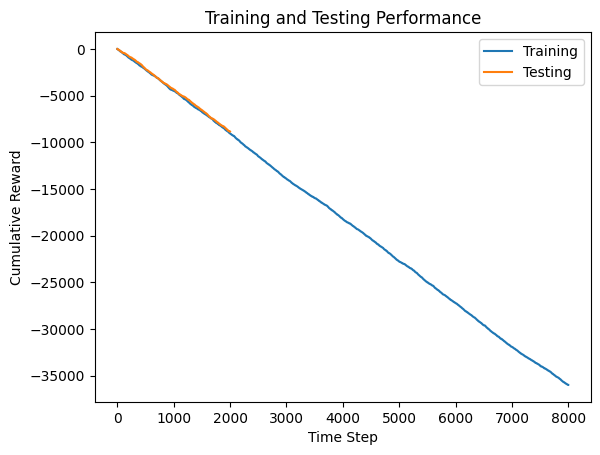

In [7]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score

class SensorEnv(gym.Env):
    def __init__(self, data):
        super(SensorEnv, self).__init__()
        self.data = data
        self.action_space = spaces.Discrete(2)  # 0: normal, 1: faulty
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(data.columns)-1,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = len(data)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.state = self.data.iloc[self.current_step, :-1].values
        return self.state

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        if action == self.data.iloc[self.current_step - 1]['IsFaulty']:
            reward = 1  # Correct prediction
        else:
            reward = -10  # Incorrect prediction
        next_state = self.data.iloc[self.current_step, :-1].values
        return next_state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Create the environment
env = SensorEnv(data)

# Train/test split
train_data = data.iloc[:int(0.8 * len(data))]
test_data = data.iloc[int(0.8 * len(data)):]

# Train
train_rewards = []
observation = env.reset()
total_reward = 0
for _ in range(len(train_data)):
    action = env.action_space.sample()  # Random action for demonstration
    observation, reward, done, info = env.step(action)
    total_reward += reward
    train_rewards.append(total_reward)
    if done:
        break
print("Total reward on train data:", total_reward)

# Test
test_rewards = []
observation = env.reset()
total_reward = 0
for _ in range(len(test_data)):
    action = env.action_space.sample()  # Random action for demonstration
    observation, reward, done, info = env.step(action)
    total_reward += reward
    test_rewards.append(total_reward)
    if done:
        break
        
print("Total reward on test data:", total_reward)

# Performance metrics
accuracy = total_reward / len(test_data)
print("Accuracy:", accuracy)

# Plotting
plt.plot(range(len(train_rewards)), train_rewards, label='Training')
plt.plot(range(len(test_rewards)), test_rewards, label='Testing')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.title('Training and Testing Performance')
plt.legend()
plt.show()


Total reward on test data: -3302
Accuracy: 0.759
Precision: 0.19469026548672566


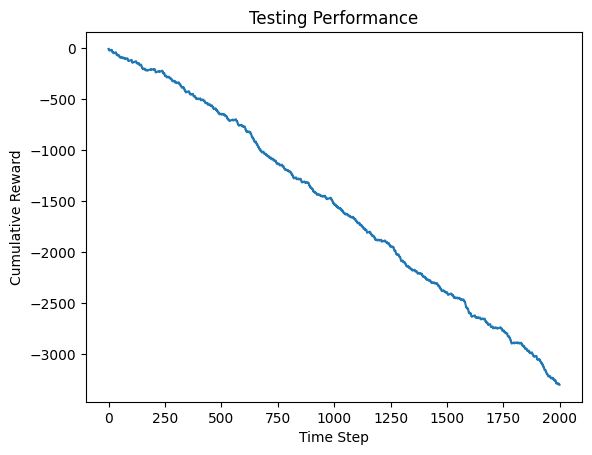

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from collections import defaultdict
import matplotlib.pyplot as plt

# Define the environment class
class SensorEnvironment:
    def __init__(self, data):
        self.data = data
        self.state = None
        self.current_step = 0
        self.max_steps = len(data)
    
    def reset(self):
        self.current_step = 0
        
    def step(self, action):
        # Execute the action
        is_faulty = self.data.iloc[self.current_step]['IsFaulty']
        reward = 1 if action == is_faulty else -10
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.data.iloc[self.current_step] if not done else None
        return tuple(next_state) if next_state is not None else None, reward, done


# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size
        
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        if next_state is None:
            td_target = reward
        else:
            td_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        
    def train(self, env, episodes):
        for episode in range(episodes):
            state = tuple(env.data.iloc[episode])
            env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state

                
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize environment and agent
train_env = SensorEnvironment(train_data)
agent = QLearningAgent(state_size=len(data.columns) - 1, action_size=2)  # Excluding the 'IsFaulty' column

# Test the agent
test_env = SensorEnvironment(test_data)
test_env.reset()
total_reward = 0
predictions = []
rewards = []  # Track rewards over time
for _ in range(len(test_data)):
    state = test_env.data.iloc[_]
    action = agent.choose_action(tuple(state))
    next_state, reward, done = test_env.step(action)
    total_reward += reward
    rewards.append(total_reward)  # Track cumulative reward
    # Map action to 'IsFaulty' label (0 or 1)
    predicted_label = 1 if action == 1 else 0
    predictions.append(predicted_label)

# Calculate performance measures
accuracy = accuracy_score(test_data['IsFaulty'], predictions)
precision = precision_score(test_data['IsFaulty'], predictions)

print("Total reward on test data:", total_reward)
print("Accuracy:", accuracy)
print("Precision:", precision)

# Plot performance graph
plt.plot(range(len(rewards)), rewards)
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.title('Testing Performance')
plt.show()


Total reward on test data: 2251
Accuracy: 0.7503333333333333
Precision: 0.15172413793103448


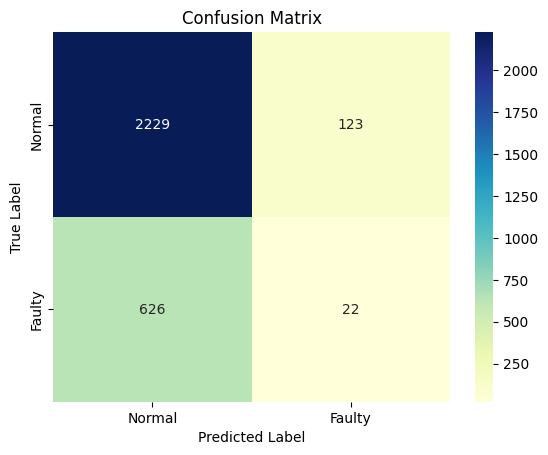

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Define the environment class
class SensorEnvironment:
    def __init__(self, data):
        self.data = data
        self.state = None
        self.current_step = 0
        self.max_steps = len(data)
    
    def reset(self):
        self.current_step = 0
        
    def step(self, action):
        # Execute the action
        is_faulty = self.data.iloc[self.current_step]['IsFaulty']
        reward = 1 if action == is_faulty else 0
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.data.iloc[self.current_step] if not done else None
        return tuple(next_state) if next_state is not None else None, reward, done


# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size
        
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        if next_state is None:
            td_target = reward
        else:
            td_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        
    def train(self, env, episodes):
        for episode in range(episodes):
            state = tuple(env.data.iloc[episode])
            env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state


# Perform label encoding for 'SensorType'
label_encoder = LabelEncoder()
data['SensorType'] = label_encoder.fit_transform(data['SensorType'])

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Initialize environment and agent
train_env = SensorEnvironment(train_data)
agent = QLearningAgent(state_size=len(data.columns) - 1, action_size=2)  # Excluding the 'IsFaulty' column

# Test the agent
test_env = SensorEnvironment(test_data)
test_env.reset()
total_reward = 0
predictions = []
for _ in range(len(test_data)):
    state = test_env.data.iloc[_]
    action = agent.choose_action(tuple(state))
    next_state, reward, done = test_env.step(action)
    total_reward += reward
    # Map action to 'IsFaulty' label (0 or 1)
    predicted_label = 1 if action == 1 else 0
    predictions.append(predicted_label)

# Calculate performance measures
accuracy = accuracy_score(test_data['IsFaulty'], predictions)
precision = precision_score(test_data['IsFaulty'], predictions)

print("Total reward on test data:", total_reward)
print("Accuracy:", accuracy)
print("Precision:", precision)

# Plot confusion matrix
conf_matrix = confusion_matrix(test_data['IsFaulty'], predictions)
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", xticklabels=['Normal', 'Faulty'], yticklabels=['Normal', 'Faulty'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Train Loss: 0.25359866135346437
Test Loss: 23.48424212106053
Total reward on test data: -3005
Accuracy: 0.7725
Precision: 0.2765957446808511


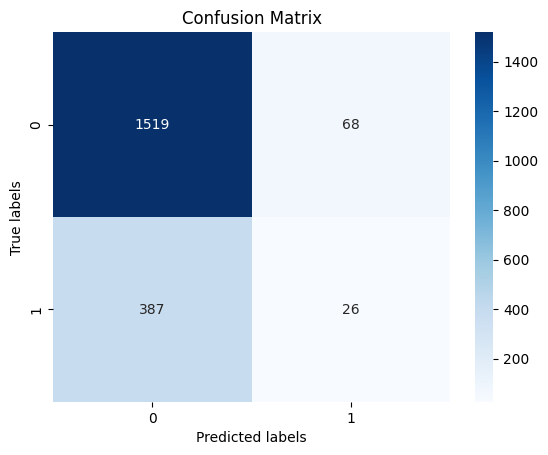

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# Define the environment class
class SensorEnvironment:
    def __init__(self, data):
        self.data = data
        self.state = None
        self.current_step = 0
        self.max_steps = len(data)
    
    def reset(self):
        self.current_step = 0
        
    def step(self, action):
        # Execute the action
        is_faulty = self.data.iloc[self.current_step]['IsFaulty']
        reward = 1 if action == is_faulty else -10
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.data.iloc[self.current_step] if not done else None
        return tuple(next_state) if next_state is not None else None, reward, done


# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size
        self.train_loss = []
        self.test_loss = []
        
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        if next_state is None:
            td_target = reward
        else:
            td_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        self.train_loss.append(td_error ** 2)  # MSE loss
        
    def train(self, env, episodes):
        for episode in range(episodes):
            state = tuple(env.data.iloc[episode])
            env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state


# Perform label encoding for 'SensorType'
label_encoder = LabelEncoder()
data['SensorType'] = label_encoder.fit_transform(data['SensorType'])

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize environment and agent
train_env = SensorEnvironment(train_data)
agent = QLearningAgent(state_size=len(data.columns) - 1, action_size=2)  # Excluding the 'IsFaulty' column

# Train the agent
episodes = min(1000, len(train_data))  # Define the number of training episodes, ensuring it doesn't exceed the length of the training data
agent.train(train_env, episodes)

# Print train loss
print("Train Loss:", np.mean(agent.train_loss))

# Test the agent
test_env = SensorEnvironment(test_data)
test_env.reset()
total_reward = 0
predictions = []
for _ in range(len(test_data)):
    state = tuple(test_env.data.iloc[_])  # Convert state to tuple
    action = agent.choose_action(state)
    next_state, reward, done = test_env.step(action)
    total_reward += reward
    # Map action to 'IsFaulty' label (0 or 1)
    predicted_label = 1 if action == 1 else 0
    predictions.append(predicted_label)
    # Calculate test loss
    if next_state is not None:
        td_target = reward
        td_error = td_target - agent.q_table[state][action]
        agent.test_loss.append(td_error ** 2)  # MSE loss

# Print test loss
print("Test Loss:", np.mean(agent.test_loss))

# Calculate performance measures
accuracy = accuracy_score(test_data['IsFaulty'], predictions)
precision = precision_score(test_data['IsFaulty'], predictions)

print("Total reward on test data:", total_reward)
print("Accuracy:", accuracy)
print("Precision:", precision)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(test_data['IsFaulty'], predictions)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameters to tune
hyperparameters = {
    'learning_rate': [0.1, 0.01, 0.001],
    'discount_factor': [0.9, 0.95, 0.99],
    'epsilon': [0.1, 0.05, 0.01]
}

# Generate combinations of hyperparameters
param_grid = ParameterGrid(hyperparameters)

best_performance = float('-inf')
best_hyperparameters = None

# Train and validate for each hyperparameter combination
for params in param_grid:
    agent = QLearningAgent(state_size=len(data.columns) - 1, action_size=2, **params)
    agent.train(train_env, episodes)  # Training on the full training data for simplicity
    test_env.reset()
    total_reward = 0
    predictions = []
    for _ in range(len(test_data)):
        state = tuple(test_env.data.iloc[_])  # Convert state to tuple
        action = agent.choose_action(state)
        next_state, reward, done = test_env.step(action)
        total_reward += reward
        predicted_label = 1 if action == 1 else 0
        predictions.append(predicted_label)
    accuracy = accuracy_score(test_data['IsFaulty'], predictions)
    if accuracy > best_performance:
        best_performance = accuracy
        best_hyperparameters = params

print("Best Hyperparameters:", best_hyperparameters)
print("Best Accuracy:", best_performance)